# IPP video codecs RD performance

In [1]:
sequence = "bus"

In [ ]:
!../sequences/$sequence/runme.sh

## IPP_codec

In [7]:
!sed -z -i 's/\n#import image_IPP as codec\n/\nimport image_IPP as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport image_IPP_adaptive as codec\n/\n#import image_IPP_adaptive as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport MP4 as codec\n/\n#import MP4 as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport IPP_compressor as codec\n/\n#import IPP_compressor as codec\n/g' RD_curve.py
!sed -z -i 's/\nimage_IPP_quantized_prediction as codec\n/\n#import image_IPP_quantized_prediction as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport image_IPP_quantized_residue as codec\n/\n#import image_IPP_quantized_residue as codec\n/g' RD_curve.py

In [8]:
!cat -n RD_curve.py | grep "import" 

     5	import config
     6	import distortion
     7	import frame
    10	#import image_interpolated_IPP as codec
    11	import image_IPP as codec
    12	#import image_IPP_adaptive as codec
    13	#import image_IPP_quantized_prediction as codec
    14	#import image_IPP_quantized_residue as codec
    15	#import MP4 as codec
    16	#import IPP_compressor as codec


In [9]:
!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [10]:
!cat -n config.py | grep "transform" 

     3	#transform = "DWT"
     4	#transform = "LP"
     5	transform = None


In [11]:
!sed -z -i 's/\ncolor = "YCoCg"\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg\n/\ncolor = "YCoCg\n/g' config.py

In [12]:
!cat -n config.py | grep "color" 

    10	#color = "YCoCg"
    11	color = "YCrCb"
    12	#color = "RGB"


In [13]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

     1	Q_step: 21 BPP: 0.4546085858585859 KBPS: 4147.776 Average AMSE: 66.84879518930626
     2	Q_step: 24 BPP: 0.33926723835578004 KBPS: 3095.42 Average AMSE: 95.92826096248947
     3	Q_step: 27 BPP: 0.24621431327160495 KBPS: 2246.42 Average AMSE: 147.12063878805415
     4	Q_step: 30 BPP: 0.17328142536475868 KBPS: 1580.992 Average AMSE: 235.22959488548676
     5	Q_step: 33 BPP: 0.11955360900673401 KBPS: 1090.788 Average AMSE: 380.9656657723063
     6	Q_step: 36 BPP: 0.08320224817620651 KBPS: 759.124 Average AMSE: 589.0837468653549
     7	Q_step: 39 BPP: 0.05917026164421998 KBPS: 539.86 Average AMSE: 835.06431124395


In [14]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/image_IPP.txt

In [15]:
!cat /tmp/image_IPP.txt

0.4546085858585859	66.84879518930626
0.33926723835578004	95.92826096248947
0.24621431327160495	147.12063878805415
0.17328142536475868	235.22959488548676
0.11955360900673401	380.9656657723063
0.08320224817620651	589.0837468653549
0.05917026164421998	835.06431124395


In [16]:
RD_image_IPP = []
with open("/tmp/image_IPP.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_image_IPP.append((float(rate), float(_distortion)))

## IPP_codec_quantized_residue

In [17]:
!sed -z -i 's/\nimport image_IPP as codec\n/\n#import image_IPP as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport image_IPP_adaptive as codec\n/\n#import image_IPP_adaptive as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport MP4 as codec\n/\n#import MP4 as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport IPP_compressor as codec\n/\n#import IPP_compressor as codec\n/g' RD_curve.py
!sed -z -i 's/\nimage_IPP_quantized_prediction as codec\n/\n#import image_IPP_quantized_prediction as codec\n/g' RD_curve.py
!sed -z -i 's/\n#import image_IPP_quantized_residue as codec\n/\nimport image_IPP_quantized_residue as codec\n/g' RD_curve.py

In [18]:
!cat -n RD_curve.py | grep "import" 

     5	import config
     6	import distortion
     7	import frame
    10	#import image_interpolated_IPP as codec
    11	#import image_IPP as codec
    12	#import image_IPP_adaptive as codec
    13	#import image_IPP_quantized_prediction as codec
    14	import image_IPP_quantized_residue as codec
    15	#import MP4 as codec
    16	#import IPP_compressor as codec


In [19]:
!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [20]:
!cat -n config.py | grep "transform" 

     3	#transform = "DWT"
     4	#transform = "LP"
     5	transform = None


In [21]:
!sed -z -i 's/\ncolor = "YCoCg"\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg\n/\ncolor = "YCoCg\n/g' config.py

In [22]:
!cat -n config.py | grep "color" 

    10	#color = "YCoCg"
    11	color = "YCrCb"
    12	#color = "RGB"


In [23]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

/home/vruiz/MRVC/src/image_IPP_quantized_residue.py:83: RuntimeWarning: divide by zero encountered in double_scalars
  block_RD_slope = current_RD_point[1] / (RD_point_for_Q_step_one[0] - current_RD_point[0])
     1	Q_step: 21 BPP: 0.30116968294051627 KBPS: 2747.824 Average AMSE: 123.72301580255682
     2	Q_step: 24 BPP: 0.22920261644219977 KBPS: 2091.208 Average AMSE: 120.18283463980079
     3	Q_step: 27 BPP: 0.17129980359147026 KBPS: 1562.912 Average AMSE: 119.63438327502452
     4	Q_step: 30 BPP: 0.12581281565656566 KBPS: 1147.896 Average AMSE: 128.82447604298184
     5	Q_step: 33 BPP: 0.09257856341189674 KBPS: 844.6719999999999 Average AMSE: 127.45845707509122
     6	Q_step: 36 BPP: 0.06930283740179574 KBPS: 632.308 Average AMSE: 127.25410589181749
     7	Q_step: 39 BPP: 0.053907565235690236 KBPS: 491.844 Average AMSE: 139.52092868792082


In [27]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/image_IPP_quantized_residue.txt

In [28]:
!cat /tmp/image_IPP_quantized_residue.txt

0.30116968294051627	123.72301580255682
0.22920261644219977	120.18283463980079
0.17129980359147026	119.63438327502452
0.12581281565656566	128.82447604298184
0.09257856341189674	127.45845707509122
0.06930283740179574	127.25410589181749
0.053907565235690236	139.52092868792082


In [29]:
RD_image_IPP_QR = []
with open("/tmp/image_IPP_quantized_residue.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_image_IPP_QR.append((float(rate), float(_distortion)))

## MP4

In [30]:
!sed -z -i 's/\nimport image_IPP as codec/\n#import image_IPP as codec/g' RD_curve.py
!sed -z -i 's/\nimport image_IPP_adaptive as codec\n/\n#import image_IPP_adaptive as codec\n/g' RD_curve.py
!sed -z -i 's/\n#import MP4 as codec\n/\nimport MP4 as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport IPP_compressor as codec\n/\n#import IPP_compressor as codec\n/g' RD_curve.py
!sed -z -i 's/\nimage_IPP_quantized_prediction as codec\n/\n#import image_IPP_quantized_prediction as codec\n/g' RD_curve.py
!sed -z -i 's/\nimport image_IPP_quantized_residue as codec\n/\n#import image_IPP_quantized_residue as codec\n/g' RD_curve.py

In [31]:
!grep import RD_curve.py

import config
import distortion
import frame
#import image_interpolated_IPP as codec
#import image_IPP as codec
#import image_IPP_adaptive as codec
#import image_IPP_quantized_prediction as codec
#import image_IPP_quantized_residue as codec
import MP4 as codec
#import IPP_compressor as codec


In [32]:
!sed -z -i 's/\ntransform = "DWT"\n/\n#transform = "DWT"\n/g' config.py
!sed -z -i 's/\ntransform = "LP"\n/\n#transform = "LP"\n/g' config.py
!sed -z -i 's/\n#transform = None\n/\ntransform = None\n/g' config.py

In [33]:
!cat -n config.py | grep "transform" 

     3	#transform = "DWT"
     4	#transform = "LP"
     5	transform = None


In [34]:
!sed -z -i 's/\ncolor = "YCoCg"\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\ncolor = "YCoCg\n/\n#color = "YCoCg\n/g' config.py
!sed -z -i 's/\n#color = "YCoCg\n/\ncolor = "YCoCg\n/g' config.py

In [35]:
!cat -n config.py | grep "color" 

    10	#color = "YCoCg"
    11	color = "YCrCb"
    12	#color = "RGB"


In [36]:
!python RD_curve.py 1> >(tee /tmp/output >&1) | grep BPP | grep Average | cat -n

ffmpeg version n4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid --enable-libzimg --enable-nvdec --ena

frame=   60 fps=0.0 q=-1.0 Lsize=     235kB time=00:00:02.36 bitrate= 815.2kbits/s speed=11.8x    
video:234kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.452810%
[libx264 @ 0x5594e9054dc0] frame I:1     Avg QP:28.88  size: 15287
[libx264 @ 0x5594e9054dc0] frame P:59    Avg QP:29.08  size:  3788
[libx264 @ 0x5594e9054dc0] mb I  I16..4:  2.8% 60.1% 37.1%
[libx264 @ 0x5594e9054dc0] mb P  I16..4:  0.1%  0.3%  0.4%  P16..4: 38.5% 28.1% 19.7%  0.0%  0.0%    skip:12.9%
[libx264 @ 0x5594e9054dc0] 8x8 transform intra:51.5% inter:51.2%
[libx264 @ 0x5594e9054dc0] coded y,uvDC,uvAC intra: 92.5% 75.1% 49.9% inter: 41.6% 18.3% 1.9%
[libx264 @ 0x5594e9054dc0] i16 v,h,dc,p: 30% 68%  0%  2%
[libx264 @ 0x5594e9054dc0] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 21% 18% 19%  5%  6%  5%  7%  6% 11%
[libx264 @ 0x5594e9054dc0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 28% 27% 14%  5%  6%  5%  5%  6%  5%
[libx264 @ 0x5594e9054dc0] i8c dc,h,v,p: 59% 15% 20%  6%
[libx264 @ 0x5594e9054dc0] Weighted 

frame=   60 fps=0.0 q=-0.0 Lsize=N/A time=00:00:02.40 bitrate=N/A speed=15.3x    
video:12512kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
ffmpeg version n4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-

[libx264 @ 0x556d1ecf3dc0] using SAR=128/117
[libx264 @ 0x556d1ecf3dc0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x556d1ecf3dc0] profile High, level 1.3, 4:2:0, 8-bit
[libx264 @ 0x556d1ecf3dc0] 264 - core 160 r3011 cde9a93 - H.264/MPEG-4 AVC codec - Copyleft 2003-2020 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=9 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=0 weightp=2 keyint=60 keyint_min=6 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=33.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/tmp/output.mp4':
  Metadata:
    encoder         : Lavf58.45.100
    Stream #0:0: Video: h264 (libx264) (avc1 / 0x31637661), yuv420p, 352x288 [SA

frame=   60 fps=0.0 q=-0.0 Lsize=N/A time=00:00:02.40 bitrate=N/A speed=16.2x    
video:11058kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
ffmpeg version n4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-

In [37]:
!grep BPP /tmp/output | grep Average | cut -d ' ' -f 4,9 | tr ' ' '\t'  > /tmp/MP4.txt

In [38]:
!cat /tmp/MP4.txt

0.16650489267676769	32.54667744063902
0.10542841610549944	50.29215450950476
0.06767106832210999	77.13411715900321
0.04373903970258137	118.52980762485967
0.028874245931537597	181.31124252507715
0.019670226571268237	270.73671431107954
0.013685465768799102	392.55198386863435


In [39]:
RD_MP4 = []
with open("/tmp/MP4.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RD_MP4.append((float(rate), float(_distortion)))

NameError: name 'sequence' is not defined

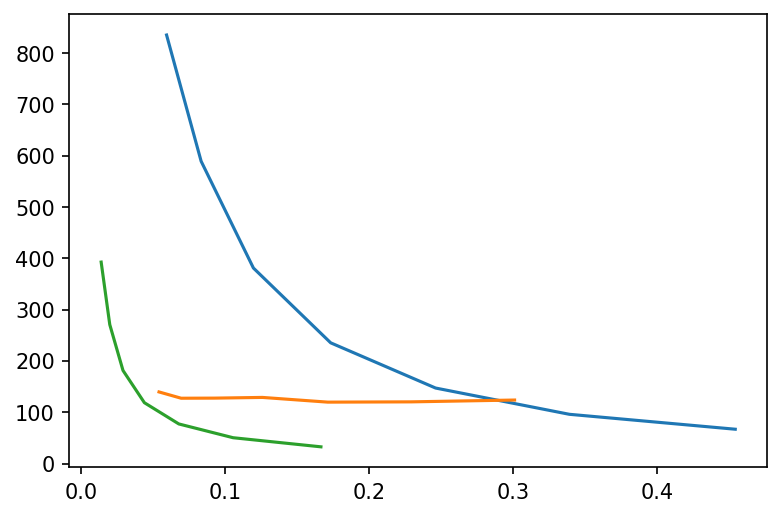

In [40]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_image_IPP), label="image_IPP")
pylab.plot(*zip(*RD_image_IPP_QR), label="image_IPP_quantized_residue")
pylab.plot(*zip(*RD_MP4), label="MP4")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()

In [25]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pylab

pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_no_intrablocks), label="No Intra-blocks")
pylab.plot(*zip(*RD_points_with_intrablocks), label="With Intra-blocks")
pylab.plot(*zip(*RD_points_MP4), label="MP4")
pylab.title(f"{sequence}")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("AMSE")
plt.legend(loc='upper right')
pylab.show()

NameError: name 'RD_points_no_intrablocks' is not defined

<Figure size 900x600 with 0 Axes>